In [56]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import random
import statistics
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import ttest_ind_from_stats
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from helperFunctions import createDataSet, prepare_features_target
import os

In [57]:
year = 2020
file_num = 1
DATA_PATH = f"/Users/nathanhoffman/Library/Mobile Documents/com~apple~CloudDocs/UniBe/3. Semester/Data Driven Diabetes Management/DDDM-Project7/data/Ohio{year}_processed/train"
files = os.listdir(DATA_PATH)
file = files[file_num]
train_set_list, scaler = createDataSet(os.path.join(DATA_PATH, file))
# Remove duplicates
train_set_list = [train_set_list[x] for x, _ in enumerate(train_set_list) if train_set_list[x].equals(train_set_list[x-1]) is False]
train_set = pd.concat(train_set_list)

DATA_PATH = f"/Users/nathanhoffman/Library/Mobile Documents/com~apple~CloudDocs/UniBe/3. Semester/Data Driven Diabetes Management/DDDM-Project7/data/Ohio{year}_processed/test"
files = os.listdir(DATA_PATH)
file = files[file_num]
test_set_list, scaler = createDataSet(os.path.join(DATA_PATH, file), scaler=scaler)
# Remove duplicates
test_set_list = [test_set_list[x] for x, _ in enumerate(test_set_list) if test_set_list[x].equals(test_set_list[x-1]) is False]
test_set = pd.concat(test_set_list)

print(f"Length of train set: {len(train_set_list)}")
print(f"Length of test set: {len(test_set_list)}")

Length of train set: 2
Length of test set: 4


In [ ]:
def subsample_df(df, start=0, stop=-1, subsamples = 1):
    df = pd.concat([df[start:stop:subsamples], df.tail(1)])
    return df

def reconstruct_samples(df, numOfValues, interpolation = "interp1d", degree = 5):
    x = df.index.values
    y = df.values
    if interpolation == "interp1d":
        f = interpolate.interp1d(x, y)
    elif interpolation == "cubicspline":
        f = interpolate.CubicSpline(x, y)
    elif interpolation == "polyfit":
        # Polynomial fitting
        coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
        f = lambda x_new: np.polyval(coefficients, x_new)  # Polynomial evaluation
    else:
        raise ValueError(f"Unsupported interpolation method: {interpolation}")
    

    
    xnew = np.arange(x[0], x[-1]+1, numOfValues)
    ynew = f(xnew)
    return xnew, ynew

def create_statistics(df, reconstruction):
    length = len(reconstruction) if len(df) > len(reconstruction) else len(df) 
    mse = np.mean((df[:length].values - reconstruction[:length])**2)
    return mse

def create_standard_metrics(train_set: list):
    total_stats = {}

    train_cbg = pd.concat(train_set).cbg
    number_of_samples = len(train_cbg)
    true_mean = train_cbg.mean()
    true_std = train_cbg.std()
    
    subsampling = [1, 2, 4, 8, 16, 32]
    interpolation = "cubicspline"

    def create_dict(mean, std, times, mse = None):
        dictonary = {"Mean": mean,
                "Std": std,
                "Times": times}
        if mse:
            dictonary["MSE"] = statistics.median(mse)

        # Transform the dictionary
        times_data = dictonary.pop("Times")  # Remove "Times" and get its dictionary
        dictonary.update(times_data)        # Add the key-value pairs from "Times"
        return dictonary
    
    def create_times(s):
        times = {
            "Time in range (70-180)" : len(s[(s >= 70) & (s <= 180)])/len(s),
            "Time in tight range (70-140)" : len(s[(s >= 70) & (s <= 140)])/len(s),
            "Time in low (<70)" : len(s[(s < 70)])/len(s),
            "Time in very low (<54)" : len(s[(s < 54)])/len(s),
            "Time in high (>180)" : len(s[(s > 180)])/len(s),
            "Time in very high (>250)" : len(s[(s > 250)])/len(s),
        }

        return times
    true_times = create_times(train_cbg)
    total_stats["True"] = create_dict(true_mean, true_std, true_times)

    for sub in subsampling:
        recon_list = []
        mse_list = []
        for i, data in enumerate(train_set):
            data = data.cbg
            subsampled_values = subsample_df(data, start=0, stop=-1, subsamples=sub)
            samples_reconstructed = reconstruct_samples(subsampled_values, 1, interpolation)

            recon_list.append(pd.Series(samples_reconstructed[1]))

            if i % 106 == 0:
                plt.figure()
                plt.plot(data.index.values*5/60, data)
                plt.plot(subsampled_values.index.values*5/60, subsampled_values, "r*")
                plt.plot(samples_reconstructed[0]*5/60, samples_reconstructed[1], '--')
                plt.xlabel("Time [h]")
                plt.ylabel("CBG [mg/dl]")
                plt.title(f"{interpolation} Subsampling rate: {sub}")

            mse = create_statistics(data, samples_reconstructed[1])
            mse_list.append(mse)
        recon = pd.concat(recon_list)
        recon_mean = recon.mean()
        recon_std = recon.std()
        recon_times = create_times(recon)
        total_stats[f"Subsampling rate {sub}"] = create_dict(recon_mean, recon_std, recon_times, mse_list)


    return total_stats, number_of_samples

563-ws-training_processed.csv
Number of Time Series: 59


/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # F

Sample 13534 is out of range
588-ws-training_processed.csv
Number of Time Series: 128


/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # F

575-ws-training_processed.csv
Number of Time Series: 48


/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:78: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fi

559-ws-training_processed.csv
Number of Time Series: 10


/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # F

591-ws-training_processed.csv
Number of Time Series: 105


/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # F

Sample 12128 is out of range
570-ws-training_processed.csv
Number of Time Series: 110


/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # F

540-ws-training_processed.csv
Number of Time Series: 13


/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # F

552-ws-training_processed.csv
Number of Time Series: 2


/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree


567-ws-training_processed.csv
Number of Time Series: 2


/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree


584-ws-training_processed.csv
Number of Time Series: 2


/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree


Sample 13199 is out of range
544-ws-training_processed.csv
Number of Time Series: 90


/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # F

Sample 14036 is out of range
596-ws-training_processed.csv
Number of Time Series: 17


/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # Fit polynomial of given degree
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1316391186.py:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)  # F

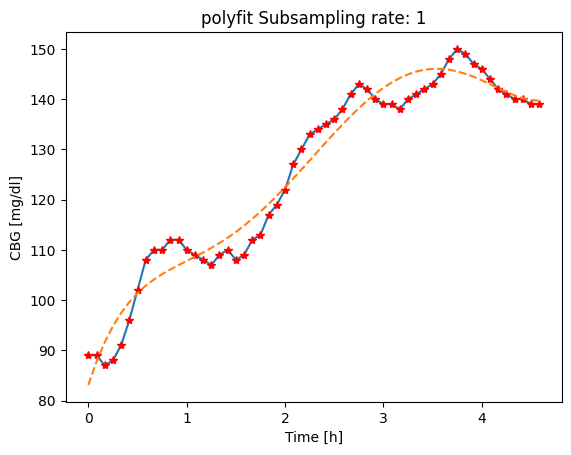

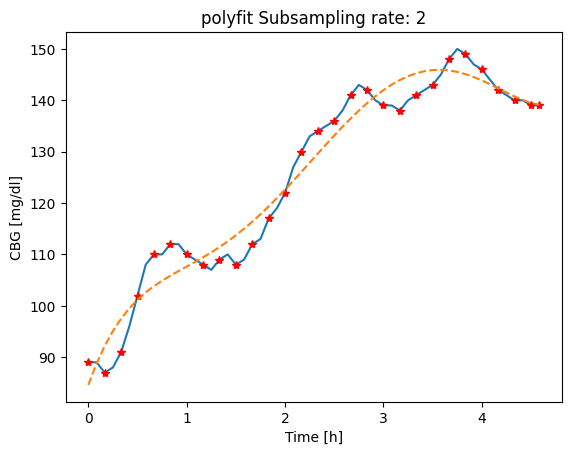

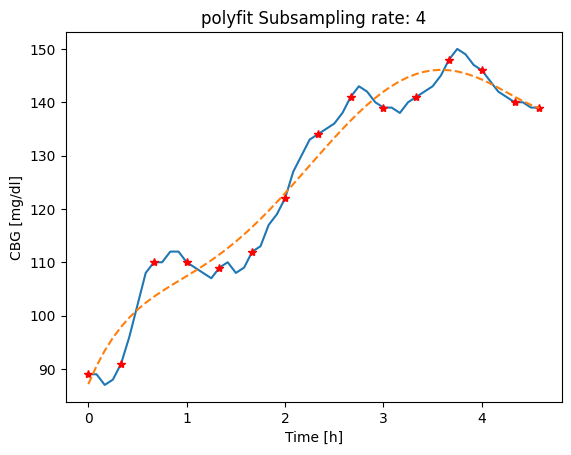

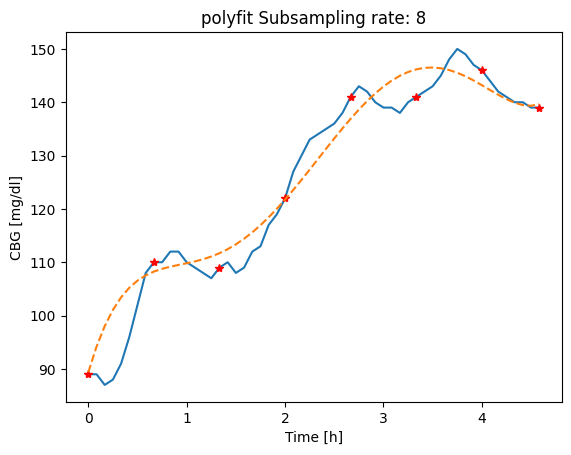

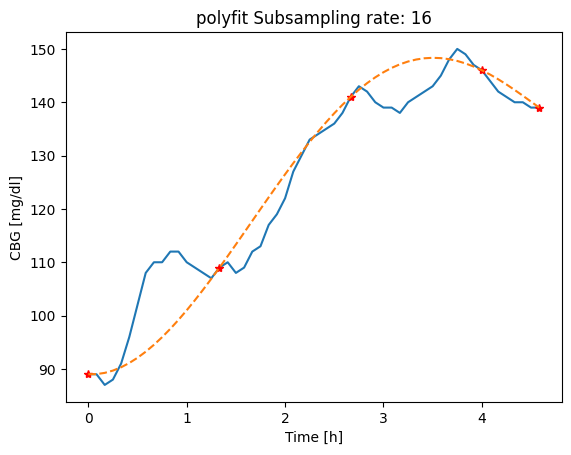

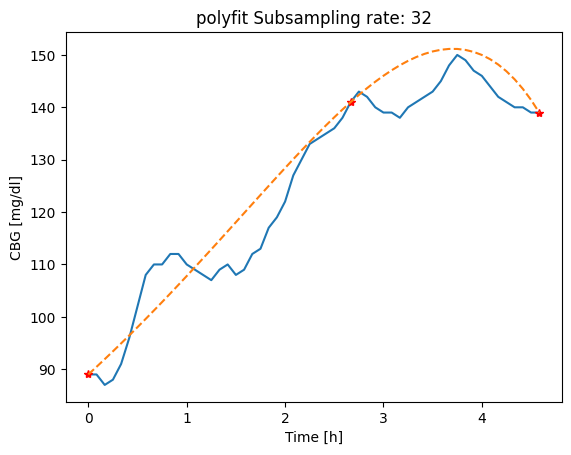

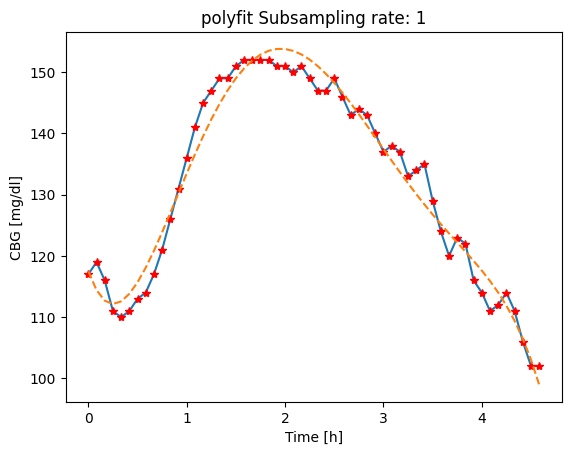

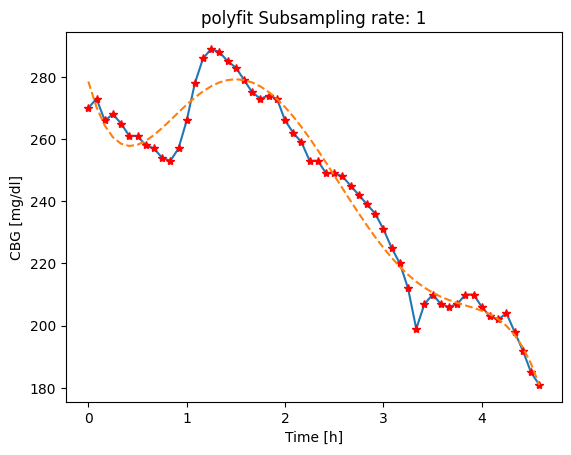

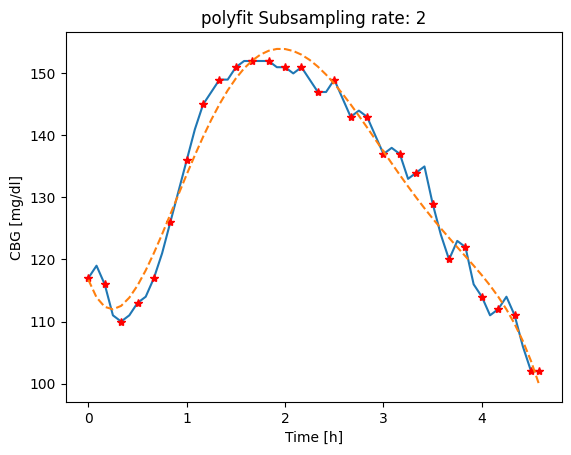

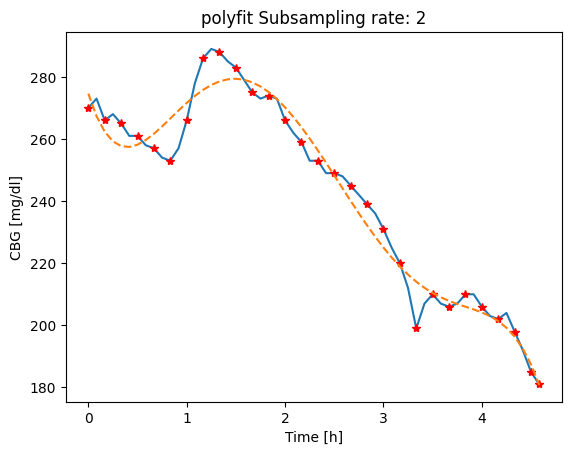

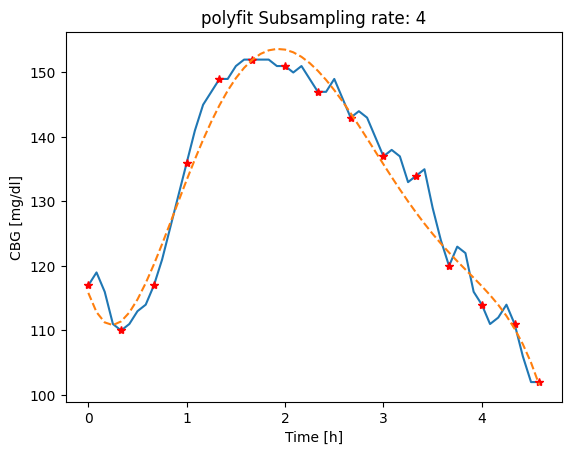

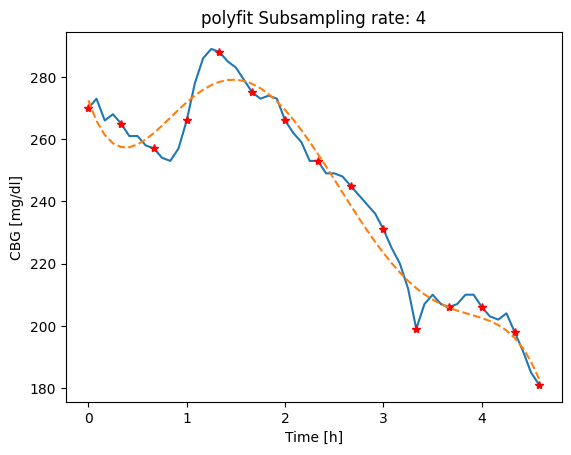

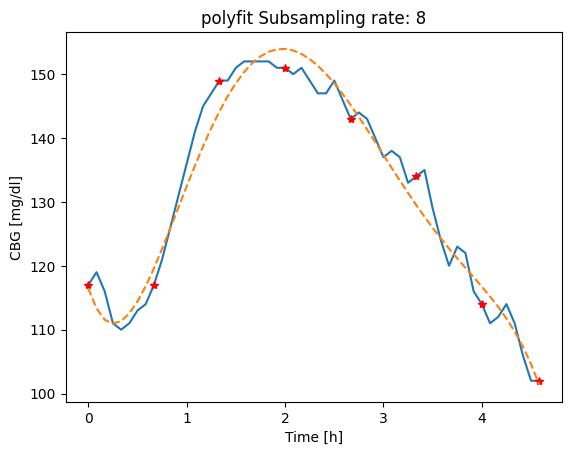

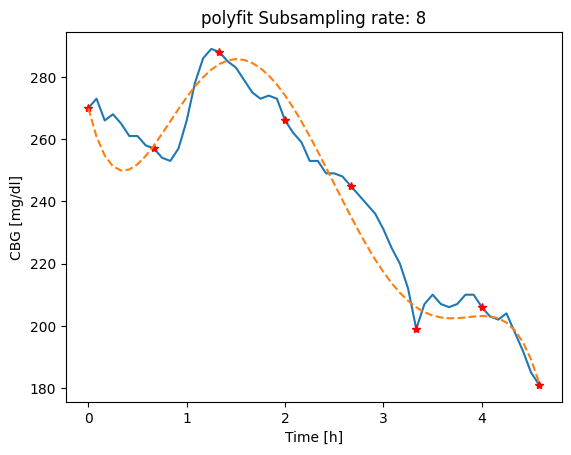

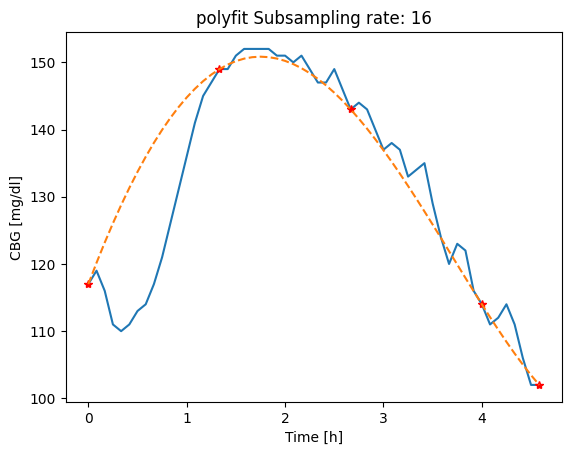

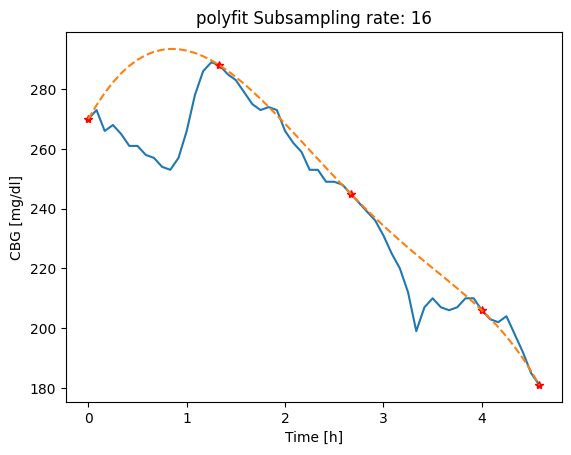

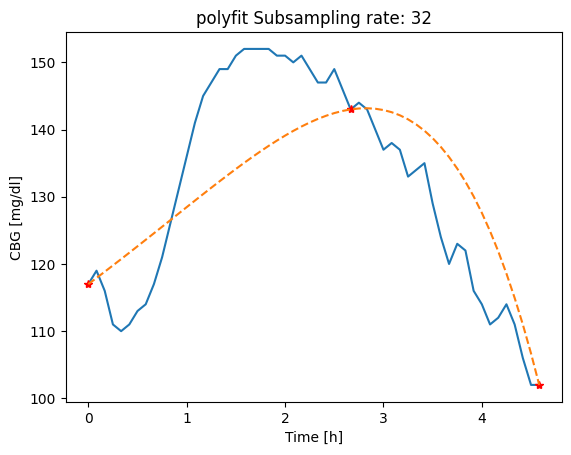

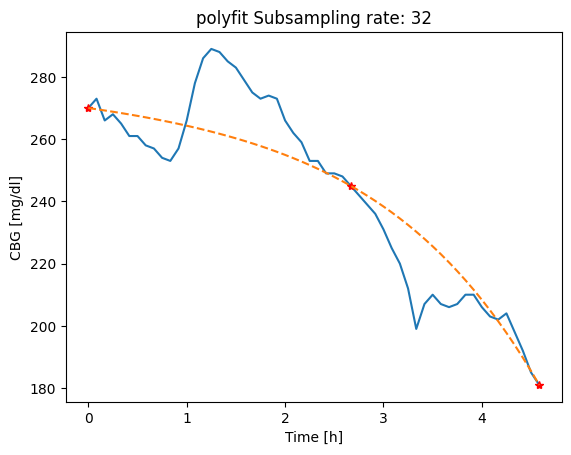

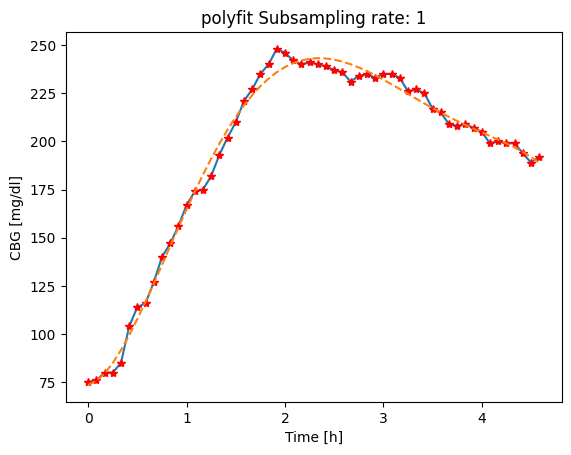

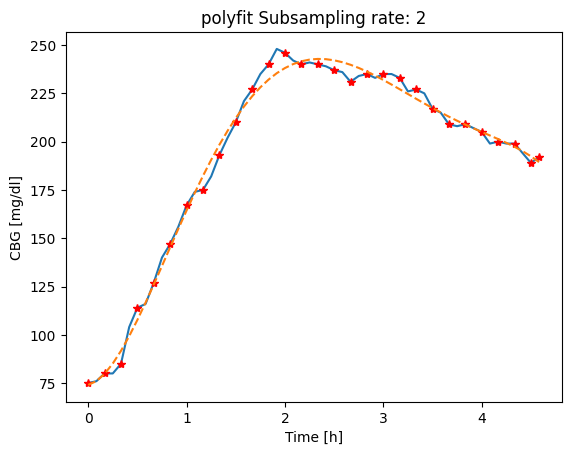

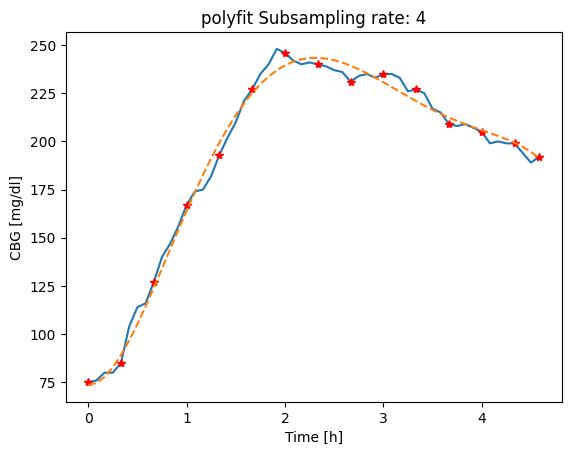

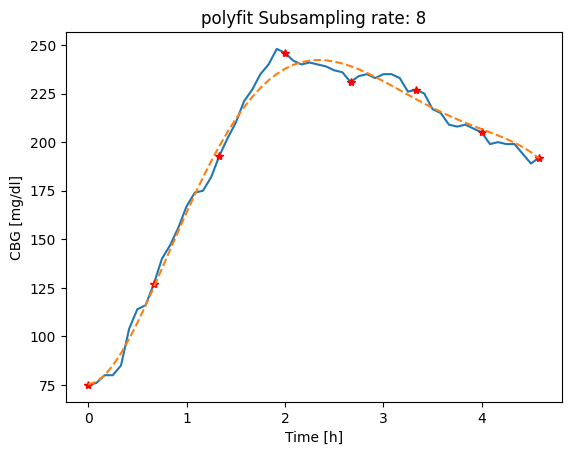

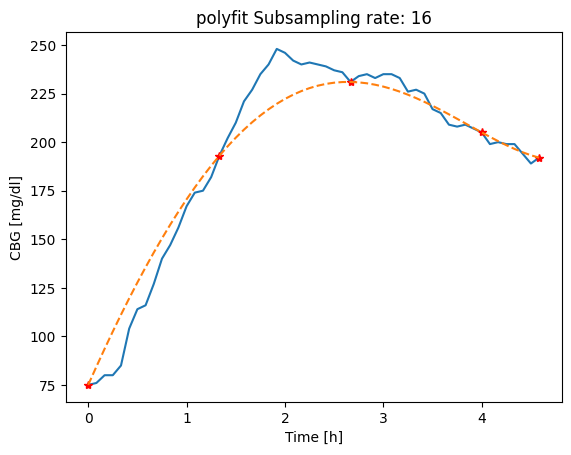

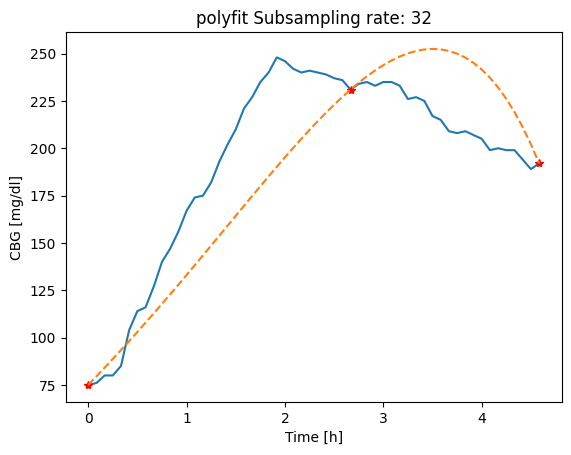

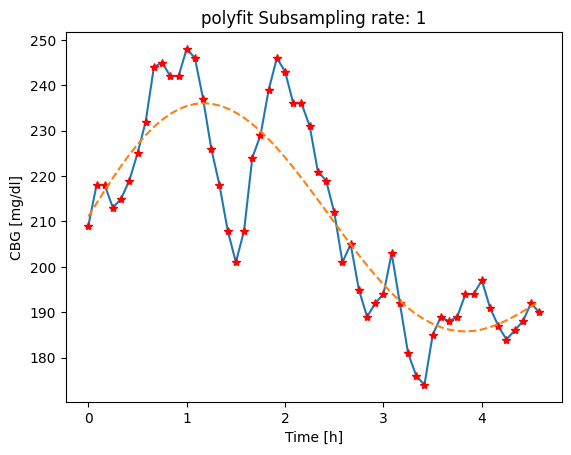

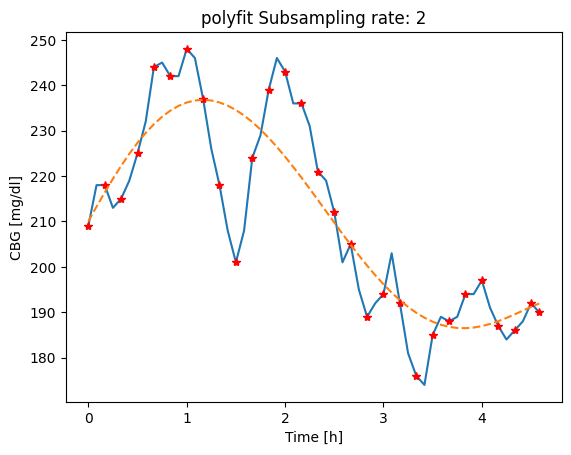

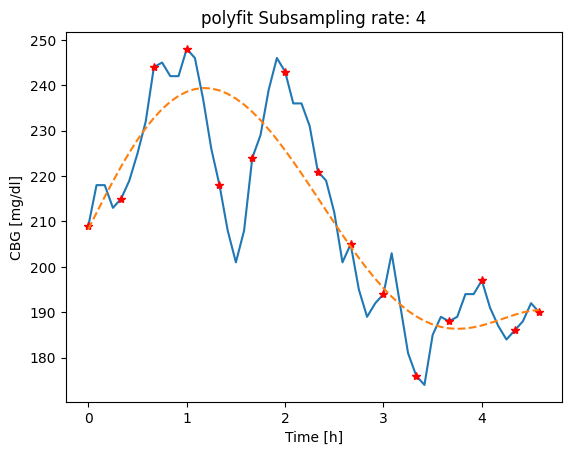

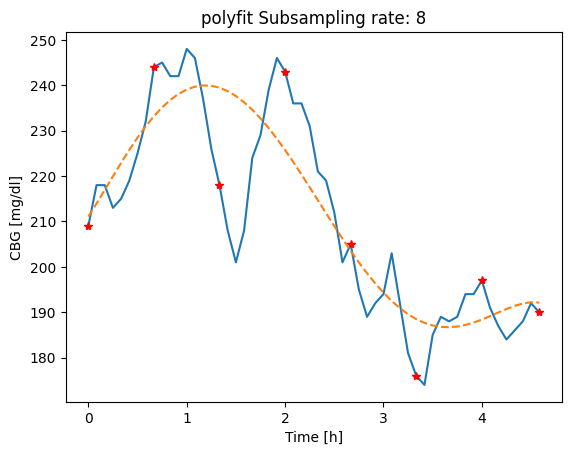

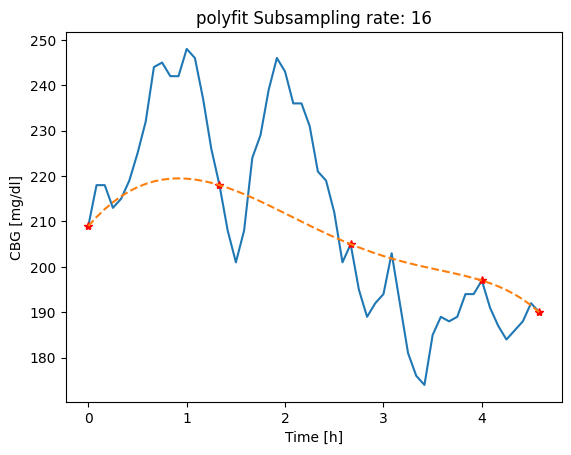

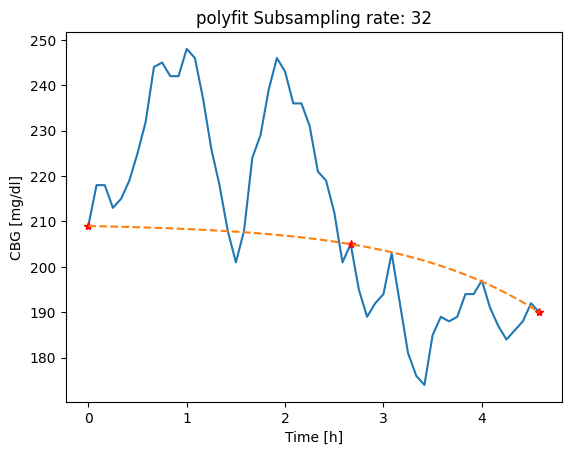

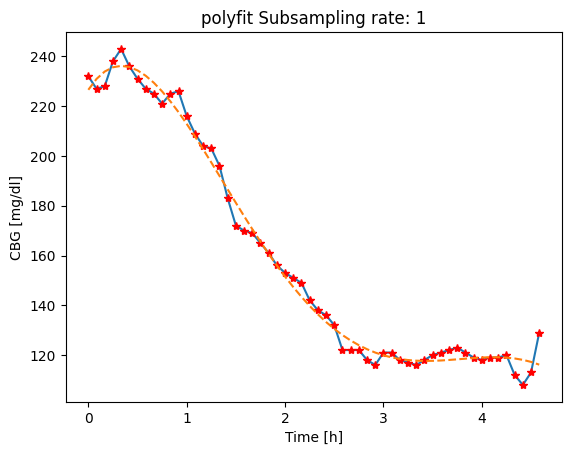

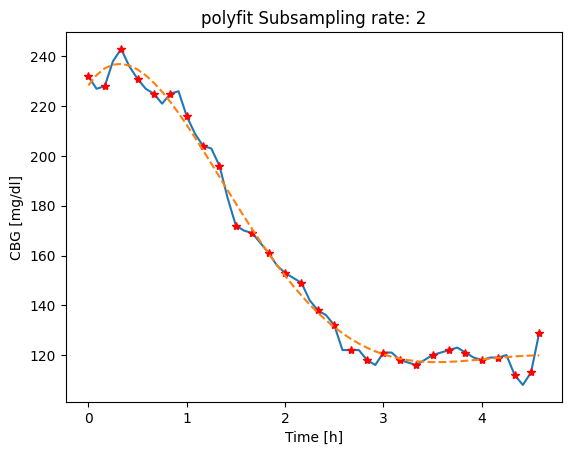

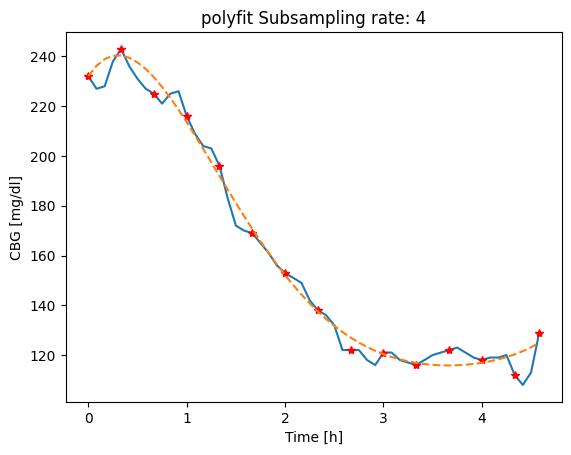

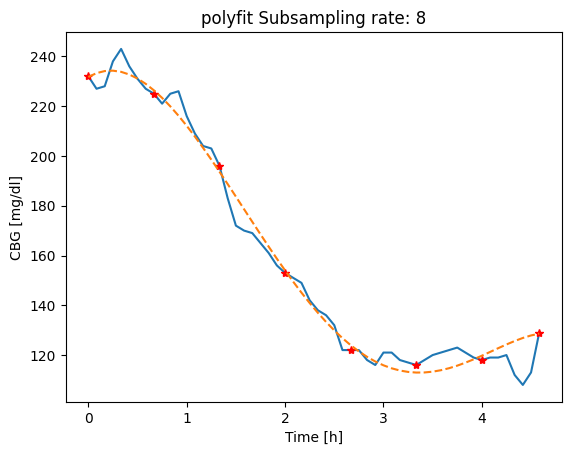

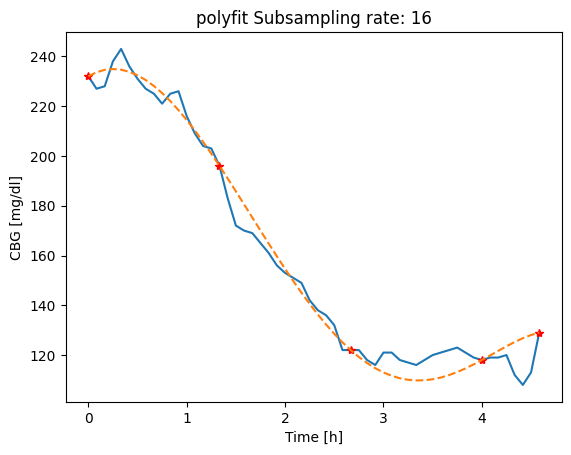

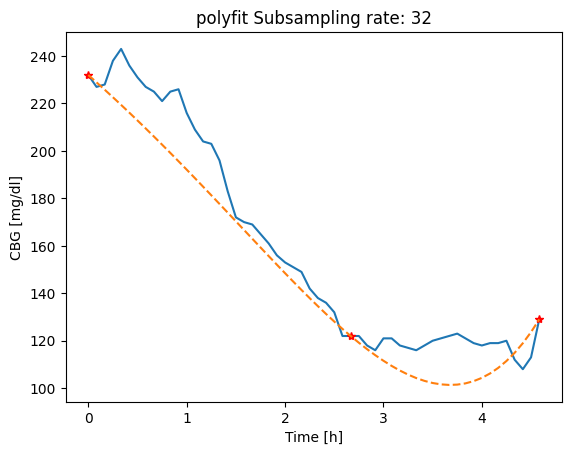

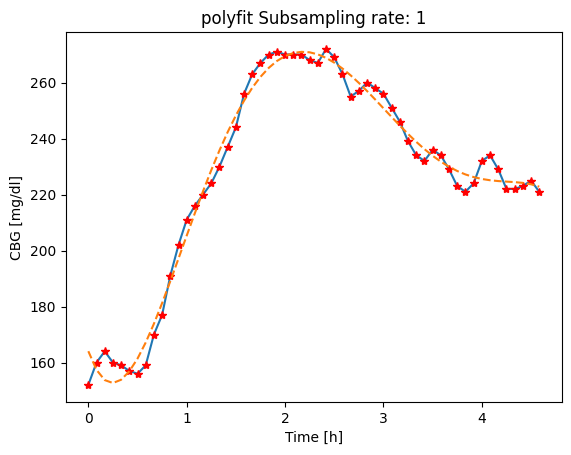

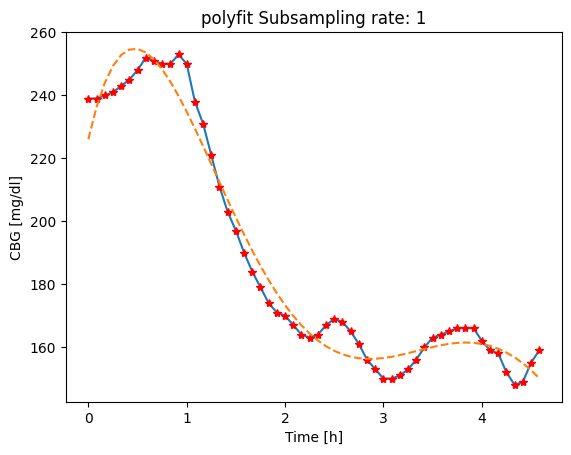

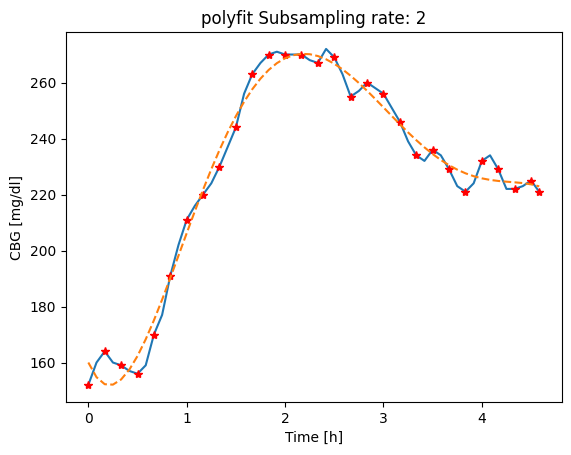

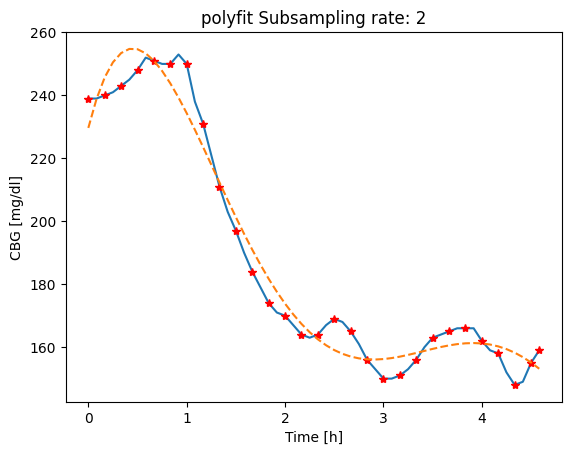

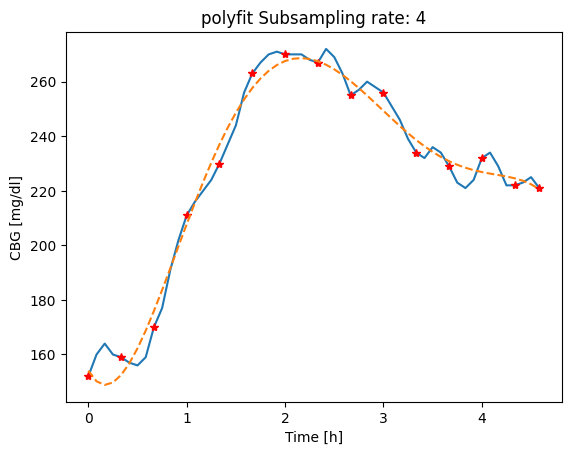

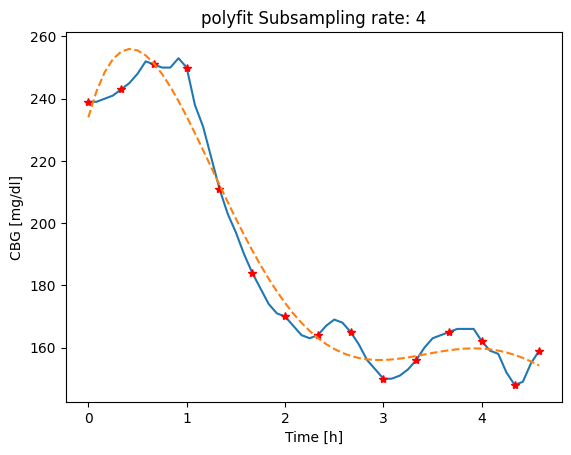

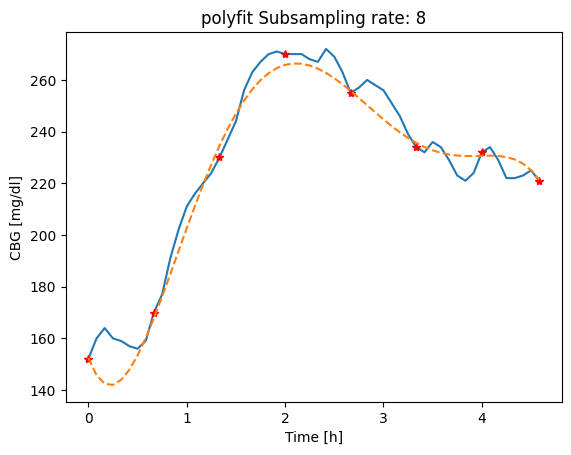

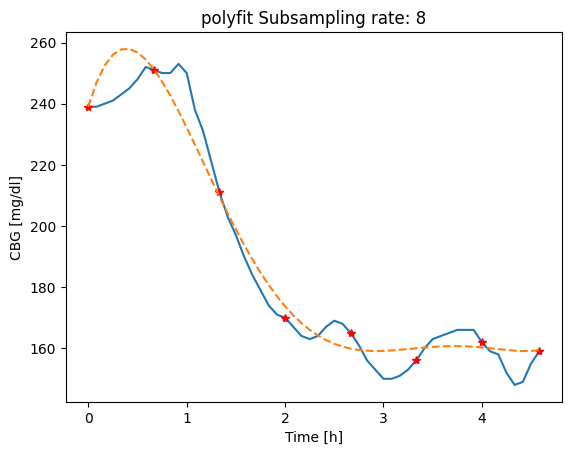

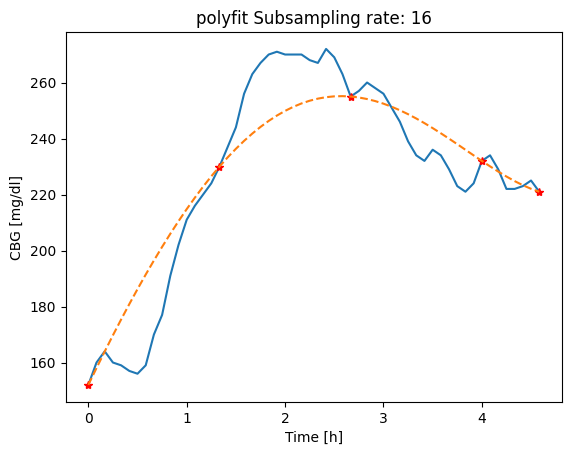

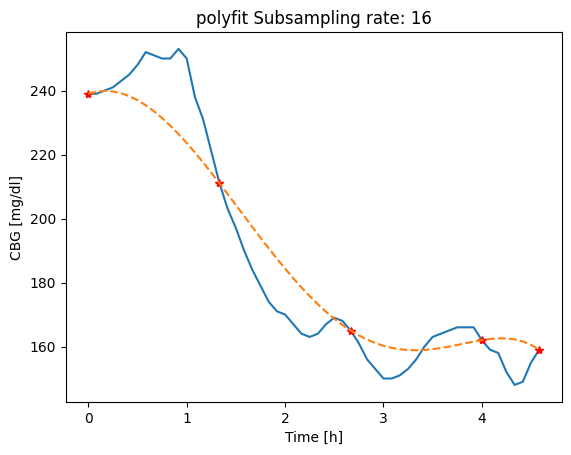

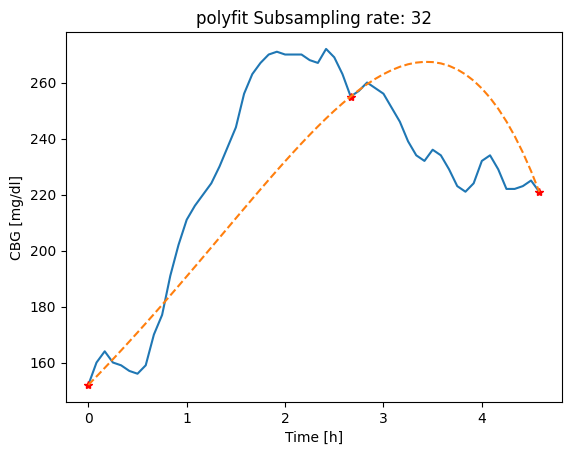

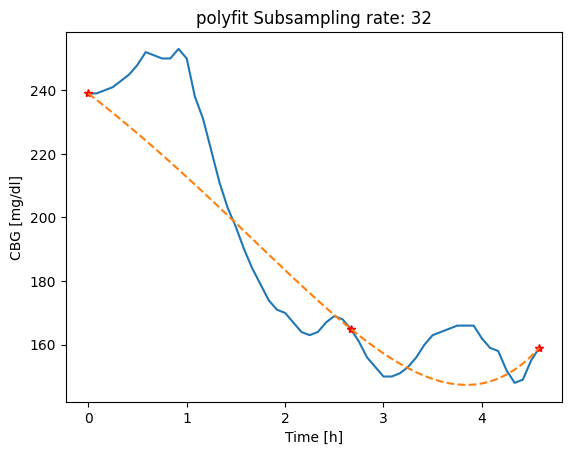

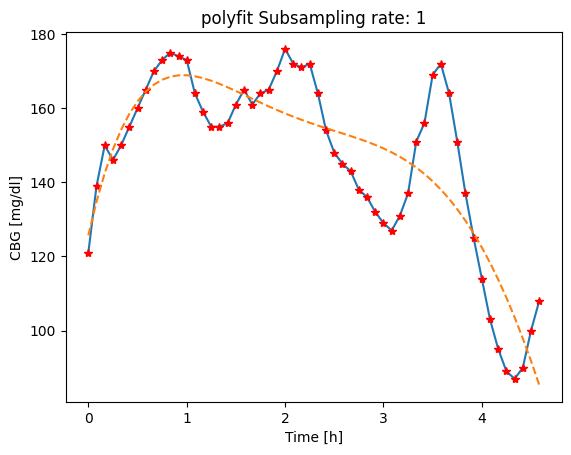

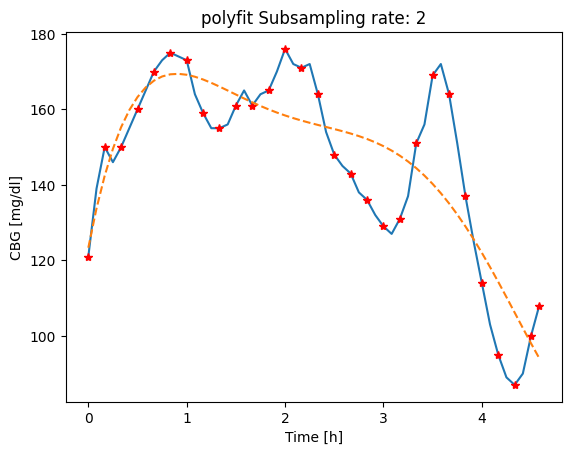

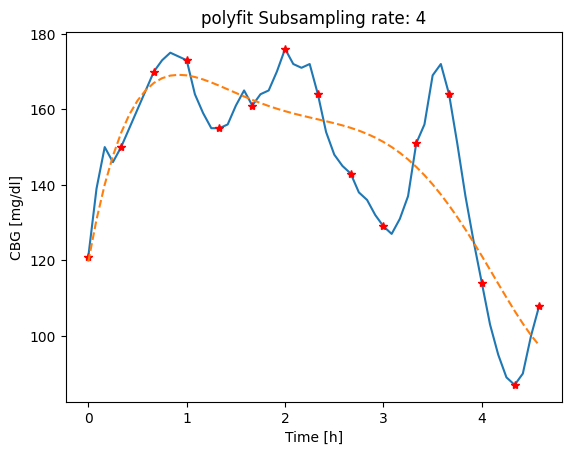

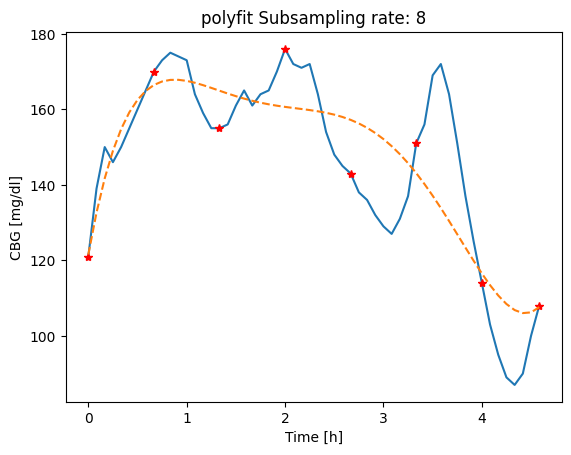

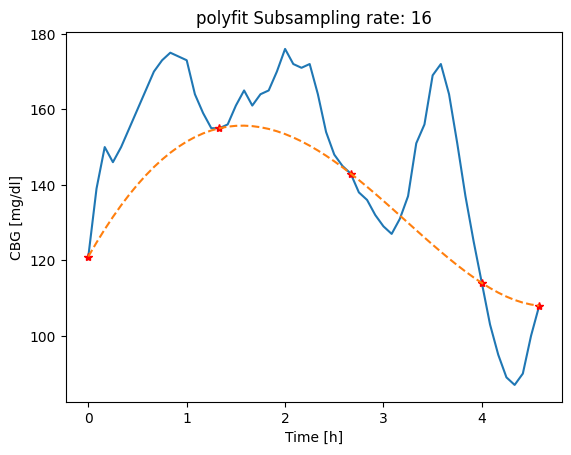

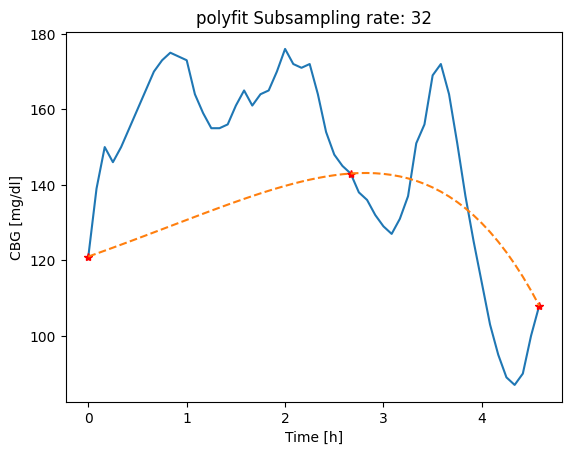

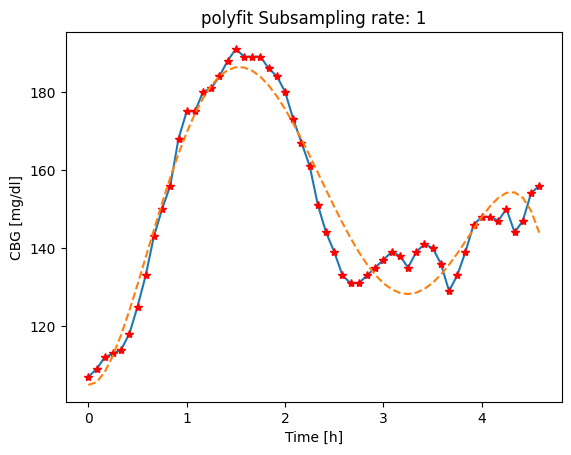

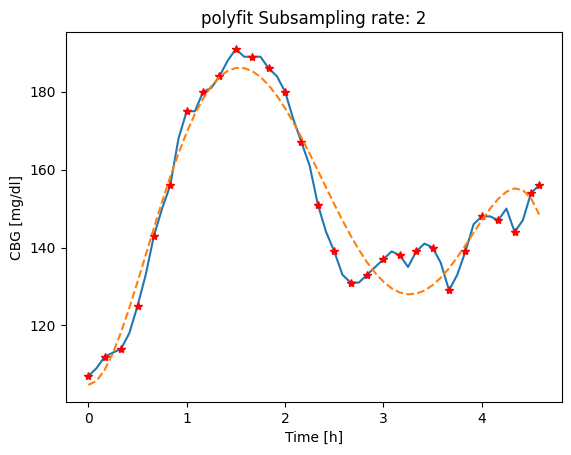

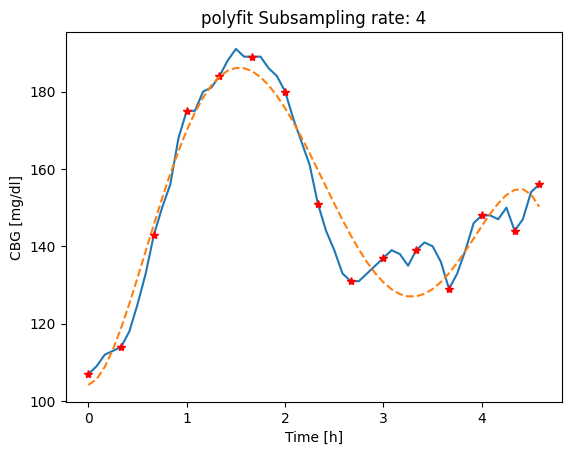

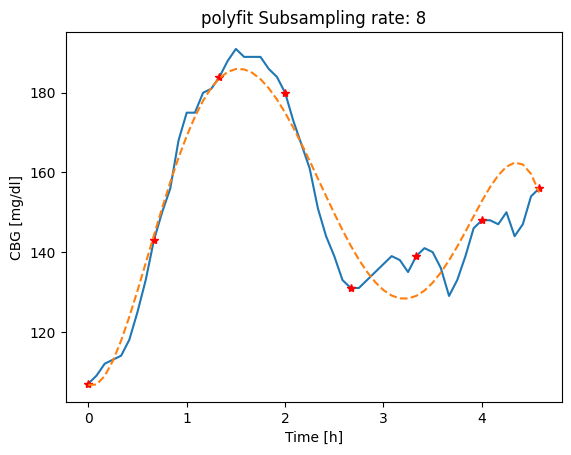

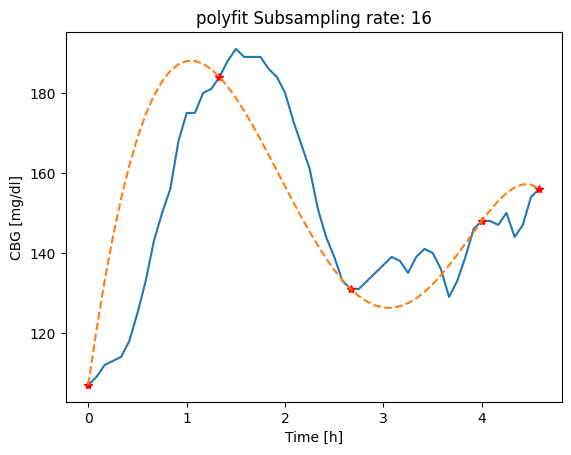

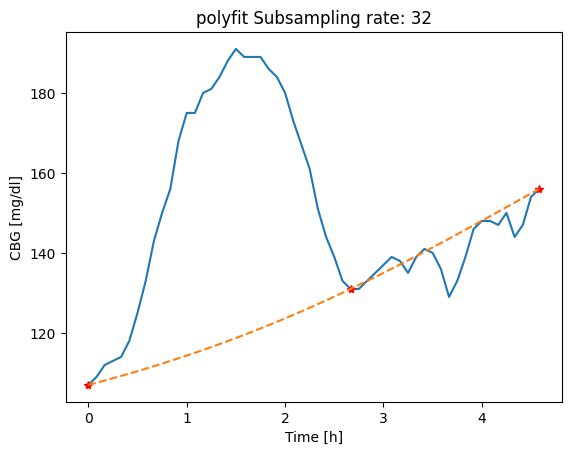

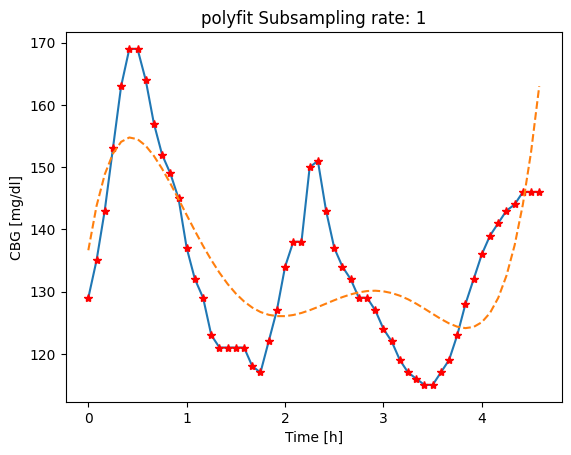

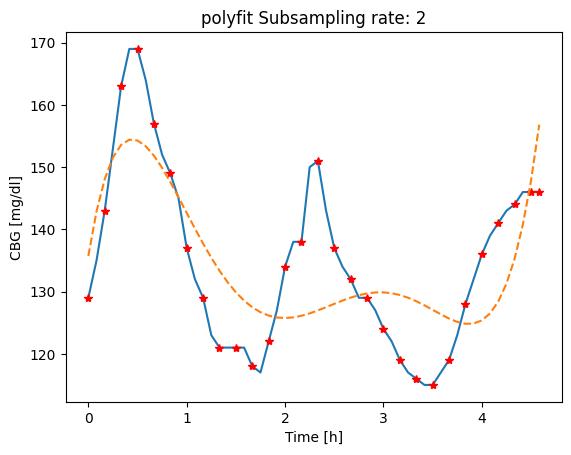

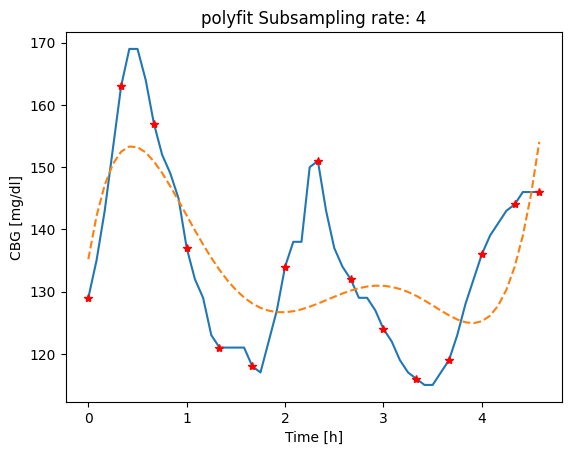

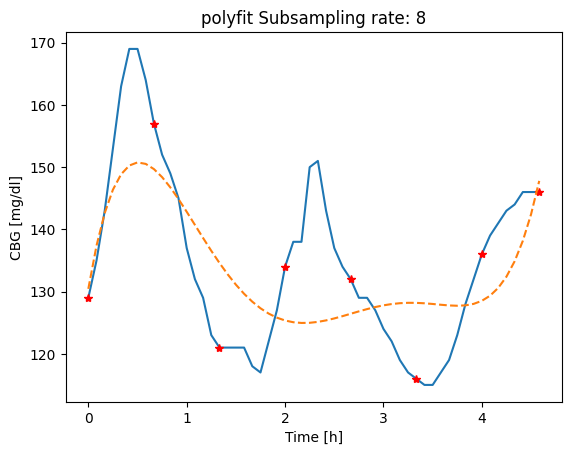

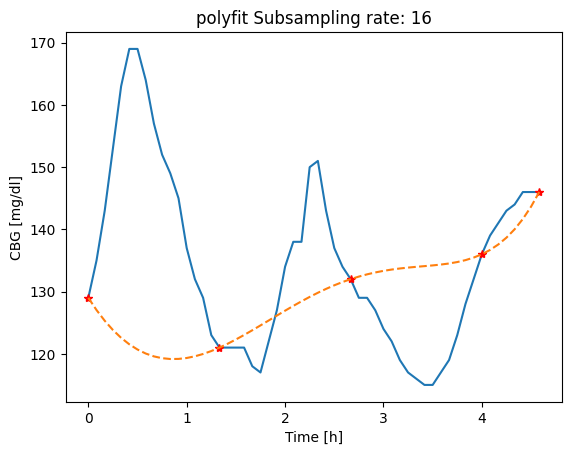

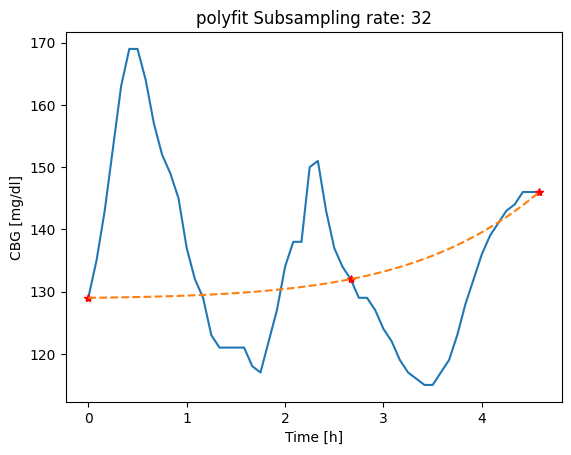

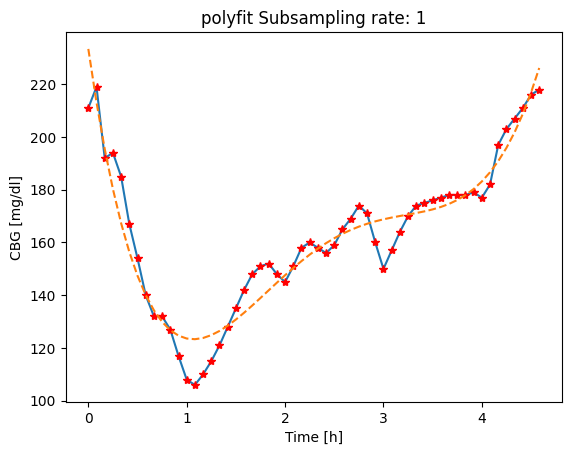

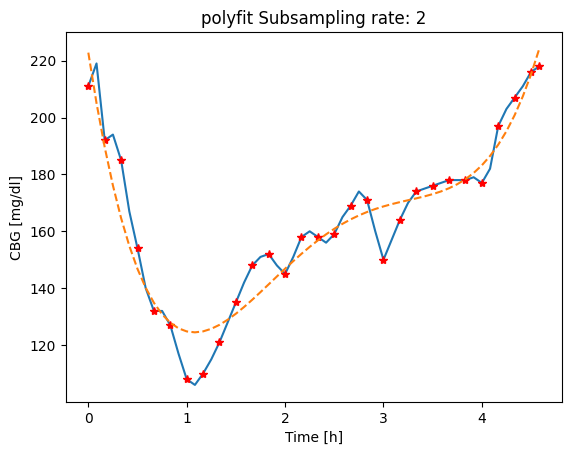

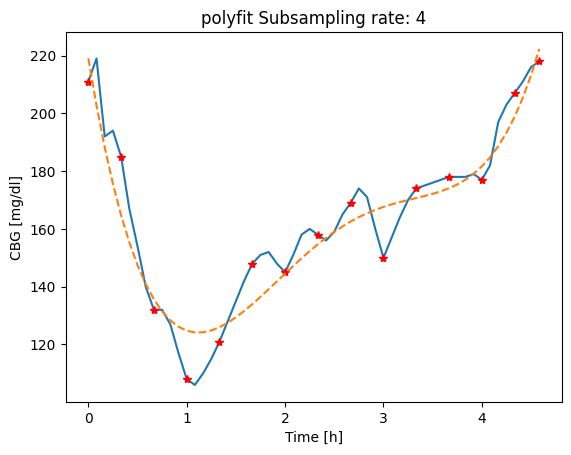

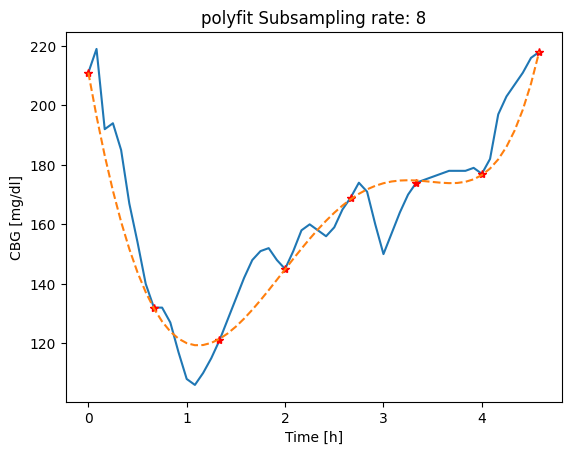

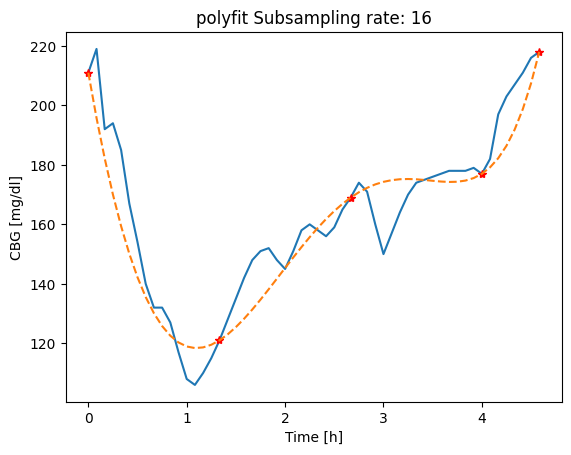

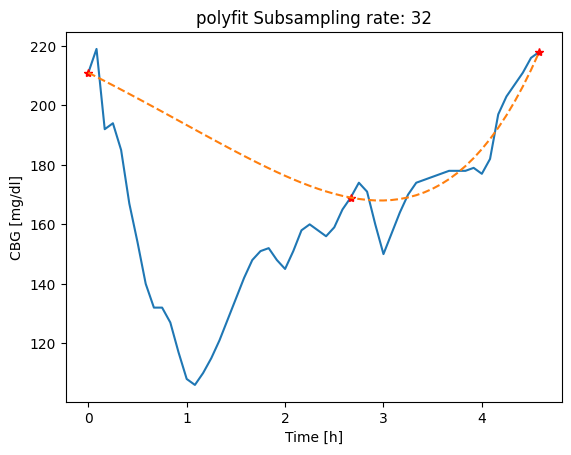

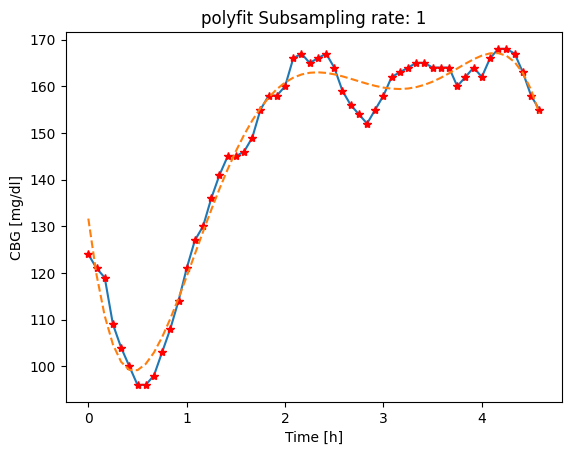

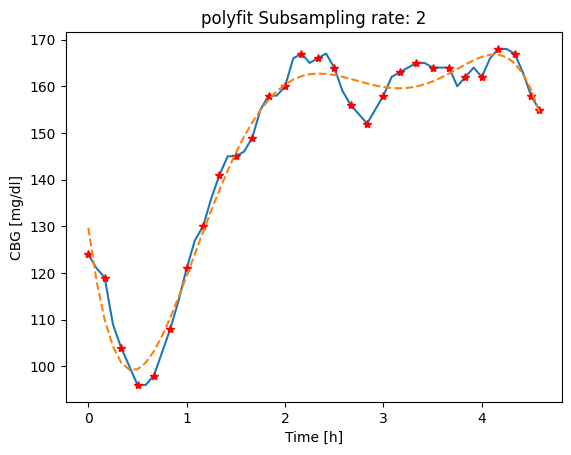

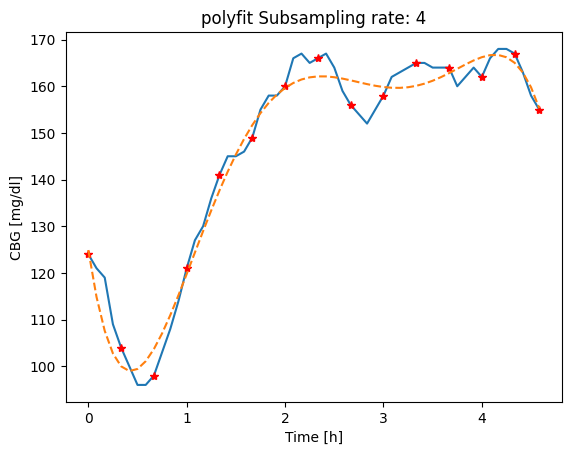

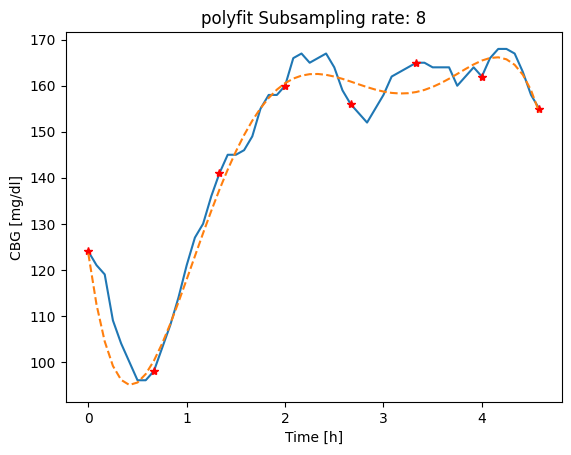

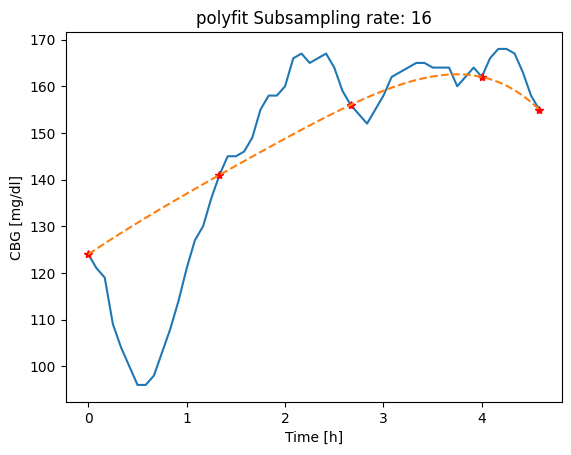

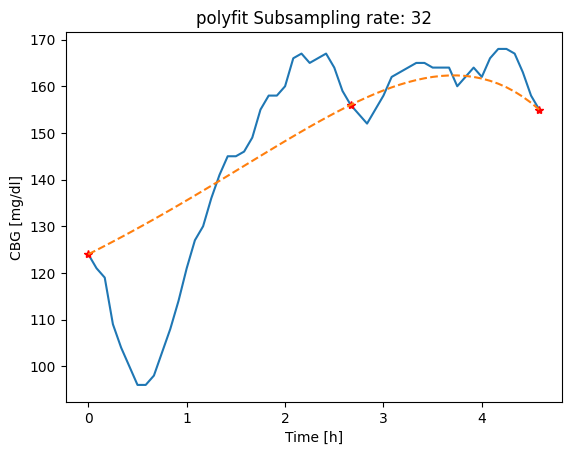

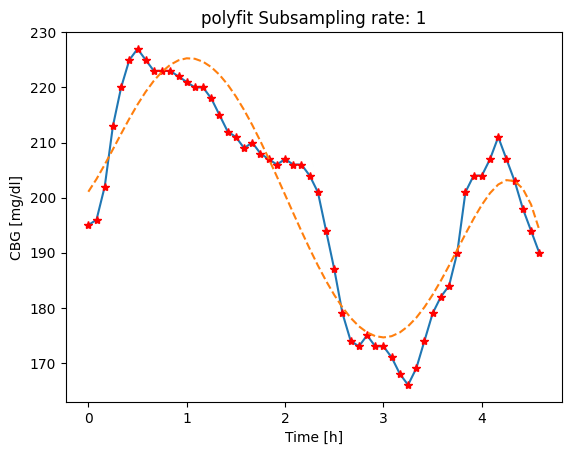

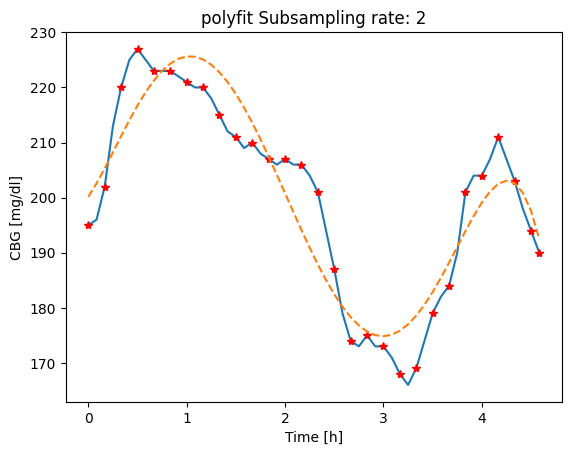

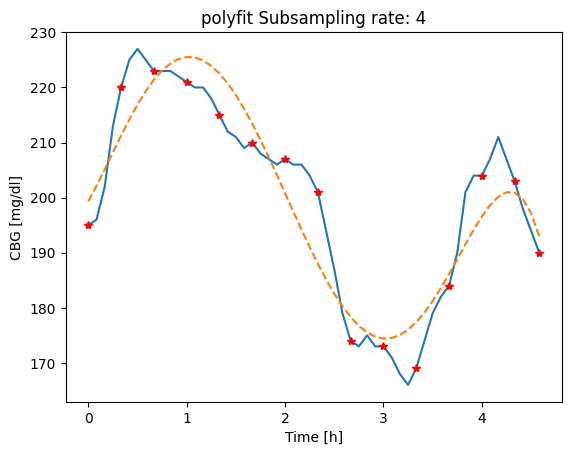

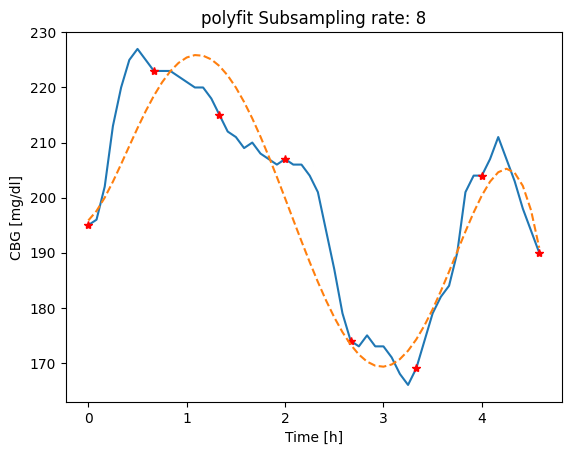

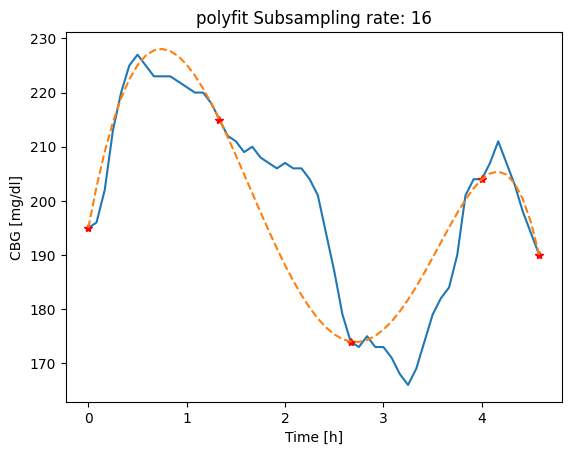

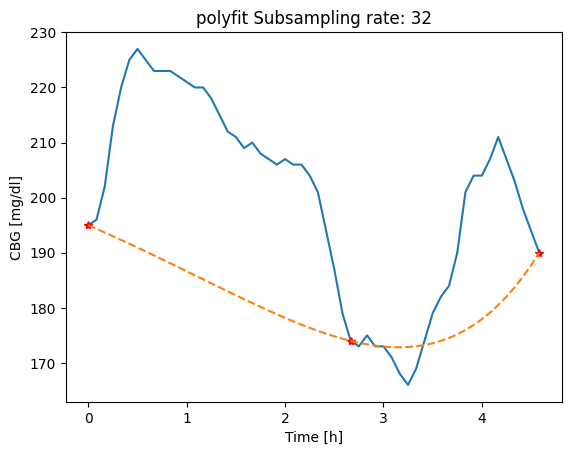

In [59]:
patients = {}
years = [2018, 2020]
for year in years:
    DATA_PATH = f"/Users/nathanhoffman/Library/Mobile Documents/com~apple~CloudDocs/UniBe/3. Semester/Data Driven Diabetes Management/DDDM-Project7/data/Ohio{year}_processed/train"
    files = os.listdir(DATA_PATH)
    for file in files:
        train_set_list, scaler = createDataSet(os.path.join(DATA_PATH, file))
        # Remove duplicates
        train_set_list = [train_set_list[x] for x, _ in enumerate(train_set_list) if train_set_list[x].equals(train_set_list[x-1]) is False]
        print(file)
        print(f"Number of Time Series: {len(train_set_list)}")
        patient_num = file.split("-")[0]
        patients[f"Patient {patient_num}"] = create_standard_metrics(train_set_list)
        

In [60]:
dfs = []

sorted_patients = dict(sorted(patients.items()))

for patient in patients:
    dfs.append(pd.DataFrame.from_dict(patients[patient][0]).T)
dfs[2]

Mean        Std  Time in range (70-180)  \
True                 136.816592  59.009308                0.697545   
Subsampling rate 1   136.816592  58.624115                0.697545   
Subsampling rate 2   136.885620  58.526541                0.697173   
Subsampling rate 4   136.914087  58.704900                0.693824   
Subsampling rate 8   137.154773  59.119797                0.691592   
Subsampling rate 16  136.217189  59.361386                0.690476   
Subsampling rate 32  127.983013  52.039471                0.744792   

                     Time in tight range (70-140)  Time in low (<70)  \
True                                     0.479911           0.109375   
Subsampling rate 1                       0.476935           0.110119   
Subsampling rate 2                       0.476935           0.109375   
Subsampling rate 4                       0.474330           0.112351   
Subsampling rate 8                       0.472842           0.114211   
Subsampling rate 16                      0.478051           0.112723   
Subsampling rate 32                      0.567336           0.106771   

                     Time in very low (<54)  Time in high (>180)  \
True                               0.026414             0.193080   
Subsampling rate 1                 0.028646             0.192336   
Subsampling rate 2                 0.028646             0.193452   
Subsampling rate 4                 0.029018             0.193824   
Subsampling rate 8                 0.029390             0.194196   
Subsampling rate 16                0.031250             0.196801   
Subsampling rate 32                0.042039             0.148438   

                     Time in very high (>250)         MSE  
True                                 0.045387         NaN  
Subsampling rate 1                   0.042783   29.818604  
Subsampling rate 2                   0.043155   29.943865  
Subsampling rate 4                   0.043899   30.363169  
Subsampling rate 8                   0.046131   37.387273  
Subsampling rate 16                  0.043155  113.394468  
Subsampling rate 32                  0.032366  537.761976

In [61]:
significance = {}
for patient in patients:
    significance[patient] = {}
    mean1 = patients[patient][0]["True"]["Mean"]
    std1=patients[patient][0]["True"]["Std"]
    nobs1=patients[patient][1]
    for subsample_rate in list(patients[patient][0].keys())[1:]:
        mean2=patients[patient][0][subsample_rate]["Mean"]
        std2=patients[patient][0][subsample_rate]["Std"]
        nobs2=patients[patient][1]
        result = ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,
                        mean2=mean2, std2=std2, nobs2=nobs2)
        print(patient, subsample_rate, result)
        p_value = result[1]
        if p_value <= 0.001:
            significance[patient][subsample_rate] = 3
        elif p_value <= 0.01:
            significance[patient][subsample_rate] = 2
            print(significance[patient][subsample_rate])
        elif p_value <= 0.05:
            significance[patient][subsample_rate] = 1
        else:
            significance[patient][subsample_rate] = 0

Patient 563 Subsampling rate 1 Ttest_indResult(statistic=-6.312333924622266e-14, pvalue=0.9999999999999496)
Patient 563 Subsampling rate 2 Ttest_indResult(statistic=-0.013761186451220403, pvalue=0.9890209238815387)
Patient 563 Subsampling rate 4 Ttest_indResult(statistic=-0.054948247870423746, pvalue=0.9561813553255772)
Patient 563 Subsampling rate 8 Ttest_indResult(statistic=-0.25446207474966465, pvalue=0.7991465202637648)
Patient 563 Subsampling rate 16 Ttest_indResult(statistic=0.24780674889892843, pvalue=0.8042916347353861)
Patient 563 Subsampling rate 32 Ttest_indResult(statistic=1.2912963938871016, pvalue=0.19664610249714604)
Patient 588 Subsampling rate 1 Ttest_indResult(statistic=9.717727665982081e-14, pvalue=0.9999999999999225)
Patient 588 Subsampling rate 2 Ttest_indResult(statistic=-0.09406003796250645, pvalue=0.9250627824792779)
Patient 588 Subsampling rate 4 Ttest_indResult(statistic=-0.1811683956681388, pvalue=0.8562379682481117)
Patient 588 Subsampling rate 8 Ttest_indRe

/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/209577266.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(rate, dfs[i].Mean[rate+1], "*"*v, c=c)
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/209577266.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(rate+1.1, dfs[i].Mean[rate+1], "*"*v, c=c)
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/209577266.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

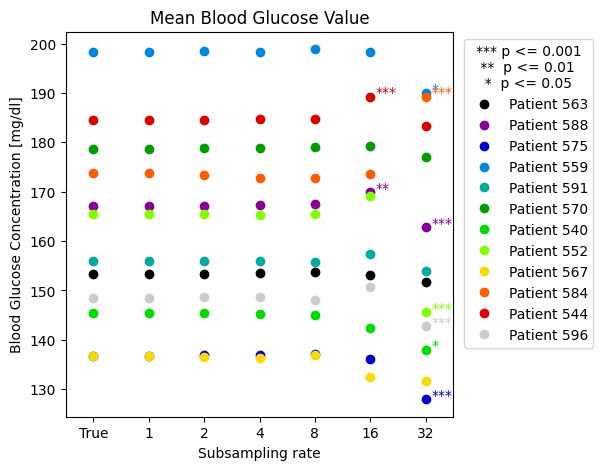

In [62]:
color = plt.cm.nipy_spectral(np.linspace(0, 1, len(dfs)))
fig = plt.figure(figsize=(5,5))
for i, (c, patient) in enumerate(zip(color, patients)):
   plt.plot(dfs[i]["Mean"], "o",label=f"{patient}", c=c)
   for rate, v in enumerate(significance[patient].values()):
        if v == 3:
            plt.text(rate+1.1, dfs[i].Mean[rate+1], "*"*v, c=c)
        elif v == 2:
            plt.text(rate+1.1, dfs[i].Mean[rate+1], "*"*v, c=c)
        elif v == 1:
            plt.text(rate+1.1, dfs[i].Mean[rate+1], "*"*v, c=c)
        else:
            plt.text(rate, dfs[i].Mean[rate+1], "*"*v, c=c)
      

plt.xticks([0, 1, 2, 3, 4, 5, 6], labels=["True", 1, 2, 4, 8, 16, 32])
plt.xlim(-0.5, 6.5)
plt.xlabel("Subsampling rate")
plt.ylabel("Blood Glucose Concentration [mg/dl]")
plt.legend(title="*** p <= 0.001\n **  p <= 0.01\n  *  p <= 0.05",bbox_to_anchor=(1.01, 1.00))
plt.title("Mean Blood Glucose Value")
plt.savefig("../../figures/all_patients_mean_cbg_values.png", bbox_inches='tight')

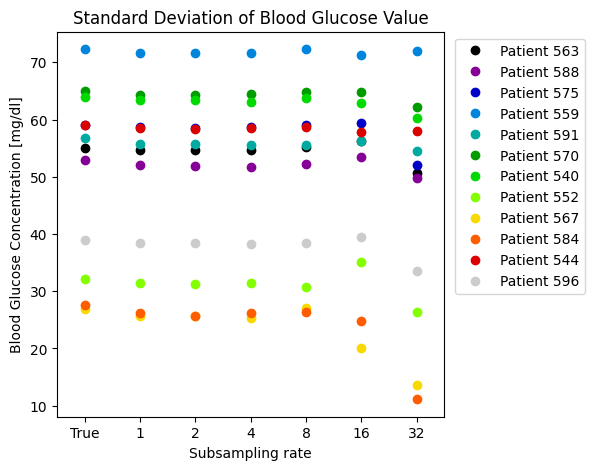

In [63]:
color = plt.cm.nipy_spectral(np.linspace(0, 1, len(dfs)))
fig = plt.figure(figsize=(5,5))
for i, (c, patient) in enumerate(zip(color, patients)):
   plt.plot(dfs[i]["Std"], "o",label=f"{patient}", c=c)

plt.xticks([0, 1, 2, 3, 4, 5, 6], labels=["True", 1, 2, 4, 8, 16, 32])
plt.xlim(-0.5, 6.5)
plt.xlabel("Subsampling rate")
plt.ylabel("Blood Glucose Concentration [mg/dl]")
plt.legend(bbox_to_anchor=(1.01, 1.00))
plt.title("Standard Deviation of Blood Glucose Value")
plt.savefig("../../figures/all_patients_std_cbg_values.png", bbox_inches='tight')

/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/3639569996.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs[0].text(rate, dfs[i].Mean[rate+1], "*"*v, c=c)
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/3639569996.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs[0].text(rate+1.1, dfs[i].Mean[rate+1], "*"*v, c=c)
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/3639569996.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior

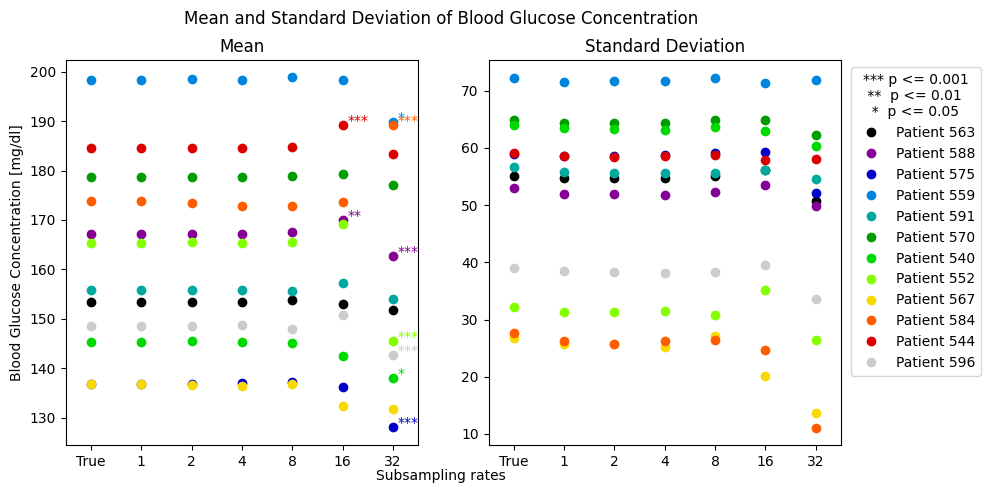

In [64]:
color = plt.cm.nipy_spectral(np.linspace(0, 1, len(dfs)))
fig, axs = plt.subplots(1, 2, figsize=(10,5))

for i, (c, patient) in enumerate(zip(color, patients)):
   axs[0].plot(dfs[i]["Mean"], "o",label=f"{patient}", c=c)
   for rate, v in enumerate(significance[patient].values()):
        if v == 3:
            axs[0].text(rate+1.1, dfs[i].Mean[rate+1], "*"*v, c=c)
        elif v == 2:
            axs[0].text(rate+1.1, dfs[i].Mean[rate+1], "*"*v, c=c)
        elif v == 1:
            axs[0].text(rate+1.1, dfs[i].Mean[rate+1], "*"*v, c=c)
        else:
            axs[0].text(rate, dfs[i].Mean[rate+1], "*"*v, c=c)
axs[0].set_xticks([0, 1, 2, 3, 4, 5, 6])
axs[0].set_xticklabels(labels=["True", 1, 2, 4, 8, 16, 32])
axs[0].set_xlim(-0.5, 6.5)
# axs[0].set_xlabel("Subsampling rate")
axs[0].set_ylabel("Blood Glucose Concentration [mg/dl]")
axs[0].set_title("Mean")

for i, (c, patient) in enumerate(zip(color, patients)):
   axs[1].plot(dfs[i]["Std"], "o",label=f"{patient}", c=c)

plt.xticks([0, 1, 2, 3, 4, 5, 6], labels=["True", 1, 2, 4, 8, 16, 32])
plt.xlim(-0.5, 6.5)

plt.legend(title="*** p <= 0.001\n **  p <= 0.01\n  *  p <= 0.05",bbox_to_anchor=(1.01, 1.00))
plt.title("Standard Deviation")
fig.suptitle("Mean and Standard Deviation of Blood Glucose Concentration")
fig.text(0.5, 0.04, 'Subsampling rates', ha='center')
plt.savefig("../../figures/all_patients_mean_std_cbg_values.png", bbox_inches='tight')



/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/2762621082.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j].set_xticklabels(["True", 1, 2, 4, 8, 16, 32])
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/2762621082.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j].set_xticklabels(["True", 1, 2, 4, 8, 16, 32])
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/2762621082.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j].set_xticklabels(["True", 1, 2, 4, 8, 16, 32])
/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/2762621082.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoca

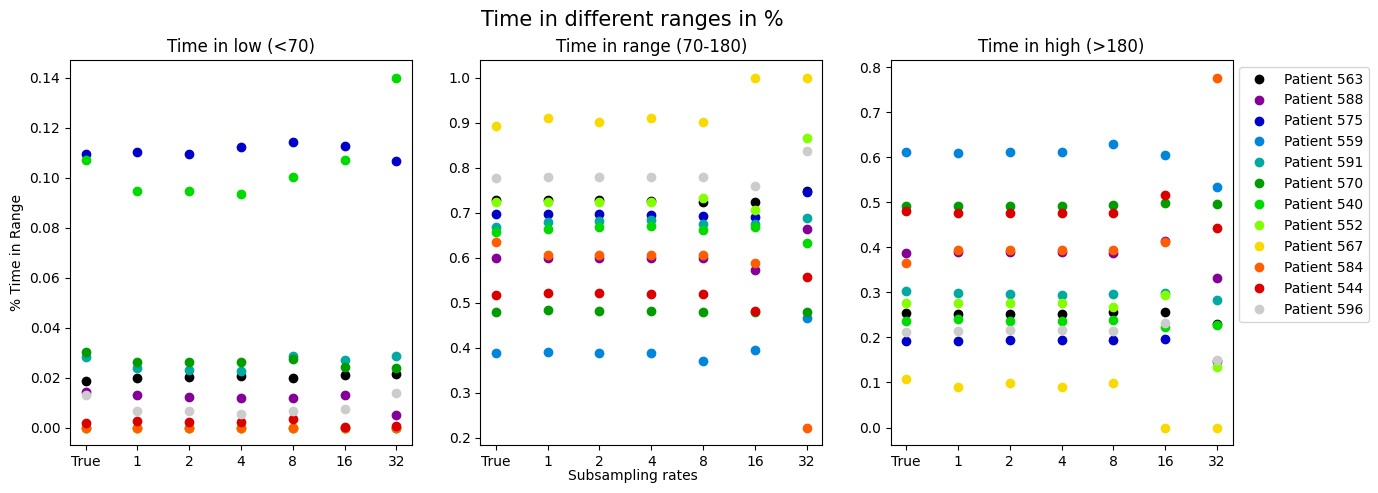

In [65]:
color = plt.cm.nipy_spectral(np.linspace(0, 1, len(dfs)))
fig, axs = plt.subplots(1, 3, figsize=(15,5))
ranges = ["Time in low (<70)", "Time in range (70-180)", "Time in high (>180)"]
for j, range in enumerate(ranges):
    for i, (c, patient) in enumerate(zip(color, patients)):
        axs[j].plot(dfs[i][range], "o",label=f"{patient}", c=c)
        axs[j].set_title(range)
        axs[j].set_xticklabels(["True", 1, 2, 4, 8, 16, 32])
        if j == 0:
            axs[j].set_ylabel("% Time in Range")
plt.legend(bbox_to_anchor=(1.00, 1.00))
fig.text(0.5, 0.04, 'Subsampling rates', ha='center')
fig.suptitle("Time in different ranges in %", fontsize=15)
plt.savefig("../../figures/all_patients_time_in_full_range.png", bbox_inches='tight')


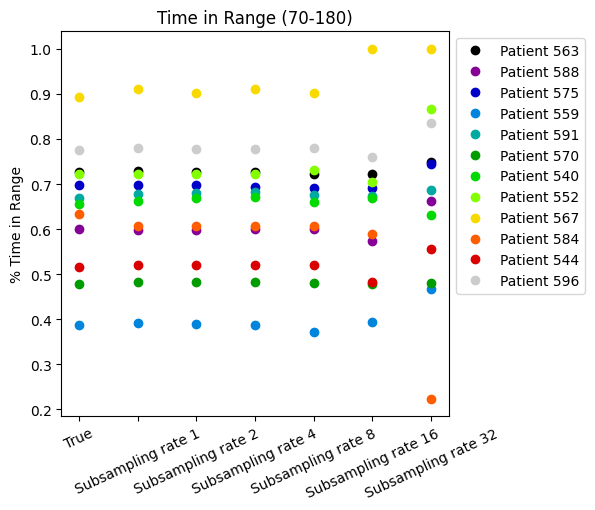

In [66]:
color = plt.cm.nipy_spectral(np.linspace(0, 1, len(dfs)))
fig = plt.figure(figsize=(5,5))
for i, (c, patient) in enumerate(zip(color, patients)):
   plt.plot(dfs[i]["Time in range (70-180)"], "o",label=f"{patient}", c=c)
plt.xticks(rotation=25)
plt.ylabel("% Time in Range")
plt.title("Time in Range (70-180)")
plt.legend(bbox_to_anchor=(1.00, 1.00))
plt.savefig("../../figures/all_patients_time_in_range.png", bbox_inches='tight')


/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_79576/1084467220.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test = pd.concat([test, df["MSE"].to_frame().fillna(0).T])


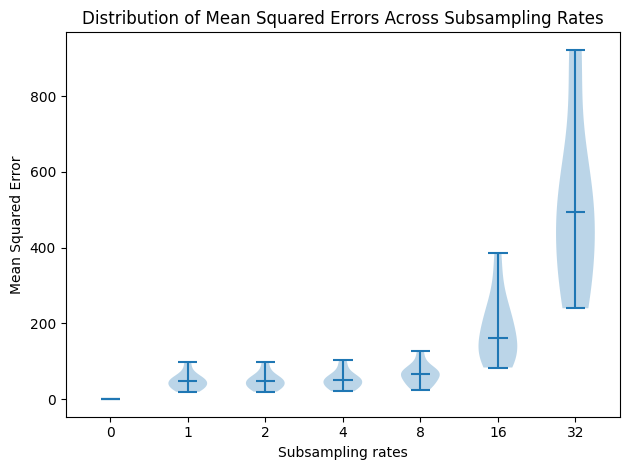

In [70]:
test = pd.DataFrame(columns=dfs[0].index.values)
for df in dfs:
    test = pd.concat([test, df["MSE"].to_frame().fillna(0).T])
test.reset_index(drop=True)
plt.violinplot(test, showmedians=True)
plt.xticks([1, 2, 3, 4, 5, 6, 7], labels=[0, 1, 2, 4, 8, 16, 32])
plt.title("Distribution of Mean Squared Errors Across Subsampling Rates")
plt.xlabel("Subsampling rates")
plt.ylabel("Mean Squared Error")
plt.tight_layout()
plt.savefig("../../figures/distribution_mses.png", bbox_inches='tight')

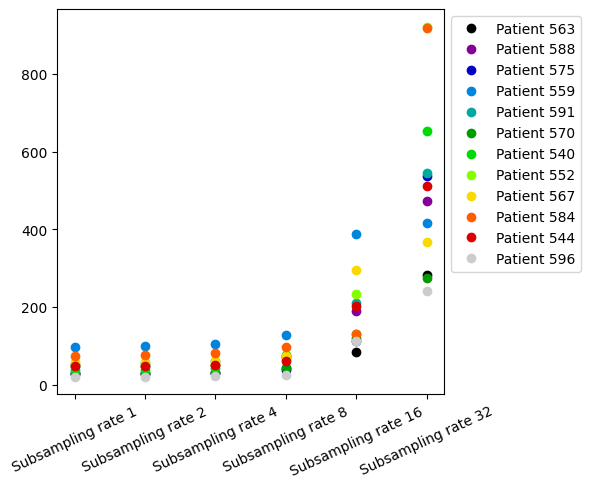

In [68]:
color = plt.cm.nipy_spectral(np.linspace(0, 1, len(dfs)))
fig = plt.figure(figsize=(5,5))
for i, (c, patient) in enumerate(zip(color, patients)):
   plt.plot(dfs[i]["MSE"], "o",label=f"{patient}", c=c)
        
plt.xticks(rotation=25)
plt.legend(bbox_to_anchor=(1.00, 1.00))

In [69]:
test = pd.DataFrame(columns=dfs[0].index.values)
for x in range(12):
    test = pd.concat([test, dfs[x]["MSE"].to_frame().fillna(0).T])
test.reset_index(drop=True)
plt.violinplot(test)
plt.xticks([1, 2, 3, 4, 5, 6, 7], labels=[0, 1, 2, 4, 8, 16, 32])
plt.title("Distribution of Mean Squared Errors Across Subsampling Rates")
plt.tight_layout()
plt.show()
plt.savefig("distribution_mses.png")

TypeError: 'str' object is not callable